# CNN Exercise 1: Convolutional Neural Networks in Keras

In this exercise we will implement a multilayer perceptron and a convolutional neural network in Keras. Keras is a framework for deep learning, which, in our case at least, runs on top of TensorFlow (a deep learning library made by Google). Where scikit-learn made it very easy for us to use a wide range of built-in models, Keras makes it very easy for us to implement and use neural network architectures which we want to define ourselves.

In [1]:
# Scientific and vector computation for python
import numpy as np
np.random.seed(42)  # Set the global random seed to make reproducible experiments (scikit-learn also use this)

# Deep learning framework
from keras.datasets import mnist  # Load MNIST dataset
from keras.models import Sequential  # Create models sequentially
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D  # Relevant layers
from keras.optimizers import Adam  # Optimizer for gradient descent
from keras.backend import clear_session  # Delete previous models
from keras.utils import to_categorical

import matplotlib.pyplot as plt  
%matplotlib inline

## 1 MLP in Keras on MNIST

Similar to previous exercises, we will now try to implement a multilayer perceptron in Keras to classify digits in the MNIST dataset. In this exercise, however, we only look at the full size MNIST dataset.

### 1.1 Get the data

In [2]:
# Load the data (already split between train and test sets)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Set number of classes
num_classes = 10

# Flatten from samples x 28 x 28 to samples x 784 (each sample is flattened from 2D picture to a vector)
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')  # Cast to float32
X_test = X_test.astype('float32')  # Cast to float32
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


### 1.2 Define and evaluate the model

Now create a neural network with two hidden layers of 25 and 10 neurons respectively, all using the Sigmoid activation function. The final layer should be a dense layer with 'num_classes' neurons and use the 'softmax' as activation function.

In [3]:
clear_session()  # Delete any existing models

# Set hyperparameters
batch_size = 128
epochs = 12
epochs = 5



# Define the input shape
input_shape = (784,)

# Now create the model
# See inspiration here: https://keras.io/getting-started/sequential-model-guide/
# ====================== YOUR CODE HERE =======================

model = Sequential()
model.add(Dense(25, activation='sigmoid', input_shape=input_shape)) # Take input of shape (*, 784)
model.add(Dense(10, activation='sigmoid')) 
model.add(Dense(num_classes, activation='softmax'))

# =============================================================

# Print a summary of the defined model
model.summary()

# Compile the model using categorical crossentropy as loss function and the Adam optimizer for gradient descent
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

# Train the model and save the loss and accuracy in history
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                19625     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 19,995
Trainable params: 19,995
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 1.7902 - acc: 0.5408 - val_loss: 1.2806 - val_acc: 0.7816
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.9812 - acc: 0.8317 - val_loss: 0.7471 - val_acc: 0.8712
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.6212 - acc: 0.8814 - val_loss: 0.5111 - val_a

### 1.3 Investigate training history

Now let us look at the training history.

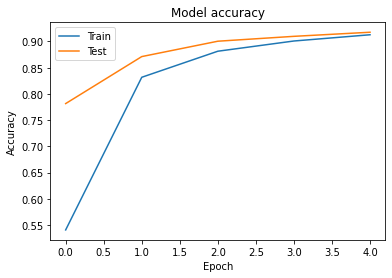

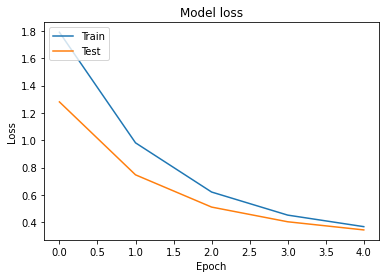

In [4]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

As we see on the plots above, we do not experience issues with overfitting, as the accuracy on the train and test sets are similar. However, we might overfit the model if we let it train for more epochs. 

If we would like better performance, we would need a larger model, and with the current approach, the number of parameters grows too quickly if we add extra layers. You can try this by adding a couple of extra layers, and/or by using more hidden units. Try using 2048 neurons in the hidden layers, and see how the accuracy improves, but how the training time becomes an issue.

## 2 CNN in Keras on MNIST

In this exercise we will implement a convolutional neural network in Keras

### 2.1 Introduction to Convolution Neural networks (CNNs)

A CNN is a neural network which use different hidden layers than the ones we know from MLPs. This includes convolutional layers (often using the ReLU as activation function) and pooling layers. Below are some very brief explanations of these layers, but we refer to the [notes from the cs231n course on CNNs](http://cs231n.github.io/convolutional-networks/) for more information. 

<br>
<div>
<a target="_blank" rel="noopener noreferrer" href="https://github.com/cs231n/cs231n.github.io/blob/master/assets/cnn/convnet.jpeg"><img src="https://github.com/cs231n/cs231n.github.io/raw/master/assets/cnn/convnet.jpeg" width="80%" style="max-width:80%;"></a>
</div>    
<br>
  
#### 2.1.2 Convolutional layers

The convolutional layer is the core building block of a Convolutional Network. Similarly to the fully connected layers we know from previously, it takes a weighted sum of some input and feeds it through an activation function. The difference is that the convolutional layer slides a kernel over the input image, calculating the weighted sum and the activation function as it goes along. The benefit of this is signifantly fewer parameters in the model.

<img src="https://cdn-images-1.medium.com/max/1600/0*1PSMTM8Brk0hsJuF.">

#### 2.1.3 Max pooling layer 

Max pooling passes divides a feature map in 2x2 blocks in the height and width dimensions, and then passes the maximum value each block. This effectively discards 75% of the input feature map. 

  <img src="https://github.com/cs231n/cs231n.github.io/raw/master/assets/cnn/maxpool.jpeg" width="40%" style="max-width:40%;"></a>
  <div>
 <br>   
<div>
  <img src="https://github.com/cs231n/cs231n.github.io/raw/master/assets/cnn/pool.jpeg" width="36%" style="max-width:50%;">


### 2.2 Get the data

In [5]:
# Load the data (already split between train and test sets)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Input image dimensions and number of classes
img_rows, img_cols = 28, 28
num_classes = 10

# Pre-process data
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


### 2.3 Define and evaluate the model
Evaluate a neural network with the following architecture:
* Convolutional layer with 32 kernels, kernel size of (3, 3), and using ReLU as activation function
* Convolutional layer with 64 kernels, kernel size of (3, 3), and using ReLU as activation function
* Max Pooling layer
* Flatten layers which flattens the input feature map to a vector
* A dense (fully connected) layer with 128 hidden units using the ReLU activation function
* A dense layer with with 'num_classes' neurons using the 'softmax' activation function

In [6]:
clear_session()  # Delete any existing models

# Set hyperparameters
batch_size = 128
epochs = 50

# Define the input shape
input_shape = (img_rows, img_cols, 1)

# Now create the model
# See inspiration here: https://keras.io/getting-started/sequential-model-guide/
# ====================== YOUR CODE HERE =======================

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# =============================================================

# Print a summary of the defined model
model.summary()

# Compile the model using categorical crossentropy as loss function and the Adam optimizer for gradient descent
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

# Train the model and save the loss and accuracy in history
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
______________________________________________

You should see very good performance, achieved after only a few epochs. Note that GPUs can easily reduce the training time by a factor 20-50, and sometimes more. 

### 2.4 Investigate training history

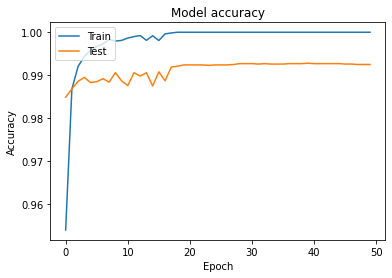

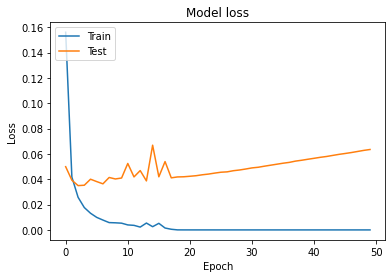

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We did not pay much attention to regularization during this exercise. Instead of using L2 regularization, we often tend to use dropout and batch normalization in CNNs. Try adding a dropout layer with a dropout rate of 0.5 just before the last dense layer, and see if this alleviates overfitting issues.

To save time, we will also skip some relevant subjects. The initialization of parameters in the individual layers used to have high significance, but today we can simply use the default ones defined in Keras. The Adam optimizer can be used in most cases, so we will no pay much attention on the choice of optimizer. If you have issues with it not converging, then try setting a lower learning rate (e.g. 1e-5). The pre-processing of the data can simply be made such that it is scaled to fit between 0 and 1. Although this is not ideal given the initilization scheme, the difference in performance is so small that it rarely matters in practice. This is particularly true if you use batch normalization, which we will talk about next time. Padding was also quickly skipped, as Keras generally takes care of this too. If you would like an in-depth understanding of how CNNs work, including the concepts mentioned above, then solve Assignment 2 of the cs231n Stanford Course.

### 2.5 Visualize learned filters

We can also access the learned filters in the convolutional layers. Let us try to visualize the 32 learned filters in the first layer. Note that white is high values and black is low values.

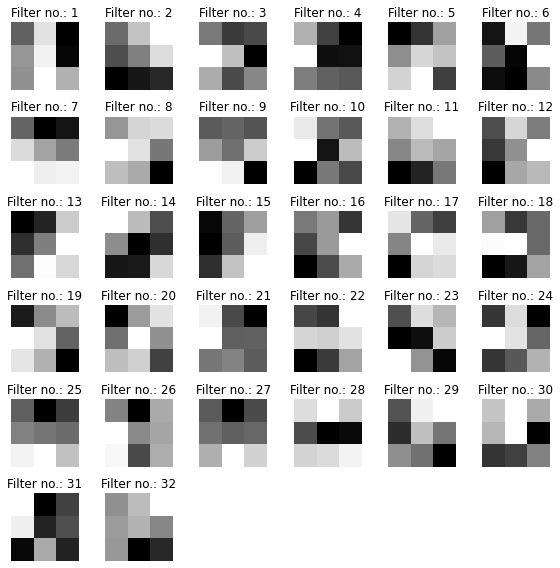

In [8]:
plt.figure(figsize=(8, 8))
for i in range(32):
    plt.subplot(6, 6, i+1)
    plt.imshow(model.layers[0].get_weights()[0][:, :, :, i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Filter no.: " + str(i + 1))
plt.tight_layout()
plt.show()

These filters are diffictult to interpret. However, take a look a the learned filters on RGB imagery below by Krizhevsky et al. Each of the 96 filters is of size 11x11x3. As these filters are convolved with input image, they detect edges and color blobs.

<div>
<img src="https://github.com/cs231n/cs231n.github.io/raw/master/assets/cnn/weights.jpeg" style="max-width:100%;"></div>